# A simple epidemic model for the spread of SARS-CoV-2

This is a simple box model that projects the infections, recoveries, and death toll of an epidemic. It is a simple 'box model' that is a member of the family of models known in epidemiology as SIR-models (for Susceptible, Infected, Recovered). We will also calculate the projected death toll, hence making this a SIRD-model. It can be (cautiously) applied to the current coronavirus pandemic by using current case counts and best estimate infection, recover, hospitalisation, and mortality rates. The model is meant to help build public awareness why __flattening the curve__ by __social distancing__ is effective and therefore important to heed. It comes with the warning that the following script was developed by a non-expert and does _NOT_ claim to make accurate predictions for the ongoing crisis.

The model solves the following set of non-linear ordinary differential equations:

\begin{align}
    \dfrac{dS(t)}{dt} &= - \beta S(t) I(t) \ , \tag{1a} \\
    \dfrac{dI(t)}{dt} &= \hspace{6pt} \beta S(t) I(t) - \gamma I(t) \ , \tag{1b} \\
    \dfrac{dR(t)}{dt} &= \hspace{49pt} \gamma I(t) (1-\delta) \ , \tag{1c} \\
    \dfrac{dD(t)}{dt} &= \hspace{49pt} \gamma I(t) \hspace{18pt} \delta \ , \tag{1d}
\end{align}
where $S$ is the population size of people susceptible to infection (not previously immunised and within social contact with infected population), $I$ is the currently infected population (some asymptomatic, some severe requiring hospitalisation), $R$ is the recovered population that is now immune and will not further contribute to infections, and $D$ the death toll. All variables are normalised by the total population size, $P$, such that $S+I+R+D = 1$. The epidemic model is governed by three parameters, the infection rate, $\beta$, the recovery rate, $\gamma$, and the mortality rate parameter, $\delta$.

The system can be characterised by the epidemic number $\mathrm{R}$, 
\begin{equation}
    \mathrm{R}_E = \dfrac{\beta S}{\gamma} \ , \tag{2} 
\end{equation}
a dimensionless number which is $>1$ when infection rates exceed recovery and mortality rates and therefore the epidemic is spreading, and $<0$ when the situation is reversed and the epidemic is retreating. 

Two further dimensionless numbers can be derived from it, the recovery number $\mathrm{R}_R$, and the mortality number $\mathrm{R}_D$,
\begin{align}
    \mathrm{R}_R &= (1-\delta)\mathrm{R}^{-1} = \dfrac{\gamma (1-\delta)}{\beta S} \ , \tag{3a} \\
    \mathrm{R}_I &= \hspace{18pt} \delta \ \mathrm{R}^{-1} = \dfrac{\gamma \delta}{\beta S} \ , \tag{3b} \\
\end{align}
which quantify the rates of recovery and mortality relative to new infections, respectively.

We will implement the equations using a simple explicit finite-difference scheme, where we discretise continuous time $t$ into $n$ discrete points in time, $t^k$, $k=1,...,n$, spaced at equal time steps $\Delta t = t^k - t^{k-1} = 1$ day. The time derivatives are discretised following the pattern,
\begin{equation}
    \dfrac{d(\cdot)}{dt} = \dfrac{(\cdot)^k - (\cdot)^{k-1}}{\delta t} \ . \tag{4}
\end{equation}
The discretised equations then are rearranged to yield explicit updates for the solution variables,
\begin{align}
    S^k &= S^{k-1} - \beta S^{k-1} I^{k-1} \Delta t \ , \tag{5a} \\
    I^k &= I^{k-1} + (\beta S^{k-1} I^{k-1} - \gamma I^{k-1}) \Delta t \ , \tag{5b} \\
    R^k &= R^{k-1} + \gamma I^{k-1} \Delta t \ , \tag{5c} \\
    D^k &= D^{k-1} + \gamma I^{k-1} \Delta t \ . \tag{5d}
\end{align}

In [219]:
# import modules for numerical calculations and for plotting
import numpy as np
import matplotlib.pyplot as plt

# tell python to allow plotting within the page
%matplotlib inline

# customise figure style to use font size 16
from matplotlib import rcParams
rcParams['font.size'] = 16

In [223]:
# create function for corona virus epidemic model
def SIRD(I0, R0, D0, P0, C0, beta, gamma, delta, f_dst, f_rst, f_snl, f_str, f_dcy, t_end):

    # set duration of model and create time line
    Time     = np.arange(0,int(t_end+1))  # model time line in days

    # create arrays to store results
    S      = np.zeros(np.size(Time))  # susceptible population
    I      = np.zeros(np.size(Time))  # infected population
    R      = np.zeros(np.size(Time))  # recovered population
    D      = np.zeros(np.size(Time))  # death toll
    RI     = np.zeros(np.size(Time))  # infection rate
    RO     = np.zeros(np.size(Time))  # outcome rate (recovery or death)
    RM     = np.zeros(np.size(Time))  # mortality rate

    # set initial conditions
    S[0]   = (P0*f_rst - I0)/P0  # initial susceptible population
    I[0]   = I0/P0               # initial infected population
    R[0]   = R0/P0               # initial recovered population
    D[0]   = D0/P0               # initial death toll
    RI[0]  = beta*f_dst * (1 - f_snl*np.sin(0))  # initial infection rate
    RO[0]  = gamma                               # initial outcome rate
    RM[0]  = delta*(1 + f_str*I[0]/(C0/P0))      # initial mortality rate
        
    # calculate epidemic SIRD-model
    # dS/dt = -RI.S.I
    # dI/dt =  RI.S.I - RR.I
    # dR/dt =           RR.I.(1-R)
    # dD/dt =           RR.I.   R
    for t in Time[1:]:
        # update variables
        S[t] = S[t-1] - RI[t-1]*S[t-1]*I[t-1]                              # update susceptible population
        I[t] = I[t-1] + RI[t-1]*S[t-1]*I[t-1] - RO[t-1]*I[t-1]             # update infected population
        R[t] = R[t-1] +                         RO[t-1]*I[t-1]*(1-RM[t-1]) # update recovered population
        D[t] = D[t-1] +                         RO[t-1]*I[t-1]*   RM[t-1]  # update death toll
        
        # update rates of change
        RI[t] = beta*f_dst * (1 + f_snl*(np.cos(2*np.pi/365*t)-1))  # update infection rate
        RO[t] = gamma                                                # update outcome rate
        RM[t] = delta*(1 + f_str*I[t-1]/(C0/P0) - f_dcy/365*t)       # update mortality rate
        
    return Time, S, I, R, D, RI, RO, RM

mega  = 1e6
kilo  = 1e3
shift = 30-0

## Model projection for UK

This projection is based on the latest case count and best estimate growth and mortality rates for the United Kingdom.

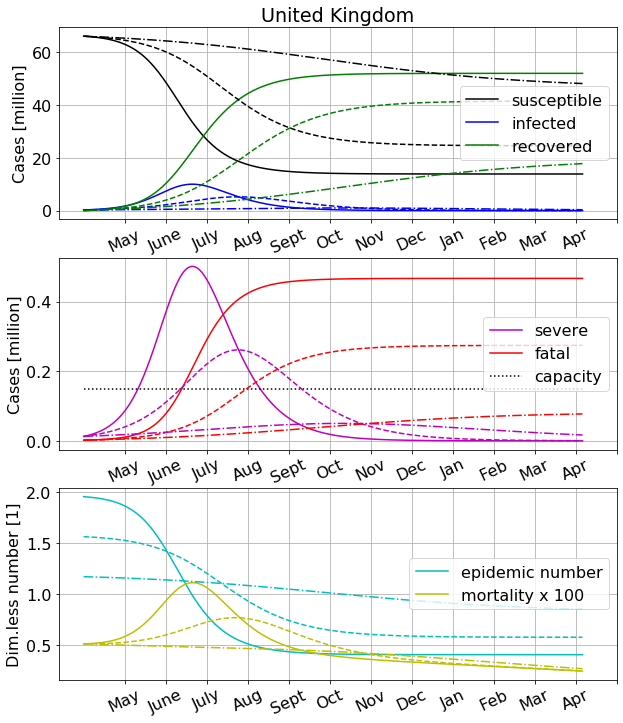

In [227]:
# set initial condition and parameter values for the model
I0    = 25150*10# current infected count
R0    = 135*20 # current recovered count
D0    = 1789   # current fatality count
P0    = 66.4e6 # population size
C0    = 1.5e5  # bed capacity of health care system
beta  = 0.14   # estimated infection rate parameter
gamma = 1/14   # estimated recovery rate parameter
delta = 0.005  # estimated mortality rate parameter
r_hsp = 0.05   # estimated hospitalisation rate
f_dst = 1.00   # factor for reduction in infection rate due to social distancing
f_rst = 1.00   # factor for reduction in effective population size due to travel restrictions
f_snl = 0.00   # increase seasonality of infection rate (>0 for norther, <0 for southern hemisphere)
f_str = 0.02   # factor for increase in mortality rate for health service at/over capacity
f_dcy = 0.50   # factor for increase in yearly decay of mortality rate (weaker form of virus spread further)
t_end = 365    # model duration in days

# run the model with the above choices
Time, S_1, I_1, R_1, D_1, RI_1, RO_1, RM_1 = SIRD(I0, R0, D0, P0, C0, beta, gamma, delta, 1.00, f_rst, f_snl, f_str, f_dcy, t_end)
Time, S_2, I_2, R_2, D_2, RI_2, RO_2, RM_2 = SIRD(I0, R0, D0, P0, C0, beta, gamma, delta, 0.80, f_rst, f_snl, f_str, f_dcy, t_end)
Time, S_3, I_3, R_3, D_3, RI_3, RO_3, RM_3 = SIRD(I0, R0, D0, P0, C0, beta, gamma, delta, 0.60, f_rst, f_snl, f_str, f_dcy, t_end)

# calculate dimensionless numbers
RE_1 = RI_1*S_1/RO_1
RE_2 = RI_2*S_2/RO_2
RE_3 = RI_3*S_3/RO_3

RR_1 = (1-RM_1)*RO_1/RI_1/S_1
RR_2 = (1-RM_2)*RO_2/RI_2/S_2
RR_3 = (1-RM_3)*RO_3/RI_3/S_3

RD_1 =    RM_1 *RO_1/RI_1/S_1
RD_2 =    RM_2 *RO_2/RI_2/S_2
RD_3 =    RM_3 *RO_3/RI_3/S_3

fig1 = plt.figure(1,figsize=(10,12))  # create figure to plot in
   
plt.subplot(3,1,1)
plt.plot(Time,S_1*P0/mega,'k-' ,Time,I_1*P0/mega,'b-' ,Time,R_1*P0/mega,'g-' , \
         Time,S_2*P0/mega,'k--',Time,I_2*P0/mega,'b--',Time,R_2*P0/mega,'g--', \
         Time,S_3*P0/mega,'k-.',Time,I_3*P0/mega,'b-.',Time,R_3*P0/mega,'g-.')
plt.ylabel('Cases [million]');
plt.grid(True)
plt.xticks(np.arange(0,t_end,30)+shift, ('May','June','July','Aug','Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr'), rotation=25)
plt.legend(['susceptible','infected','recovered'],loc=7)
plt.title('United Kingdom')

plt.subplot(3,1,2)
plt.plot(Time,I_1*r_hsp*P0/mega,'m-' ,Time,D_1*P0/mega,'r-' ,[Time[0],Time[-1]],[C0/mega,C0/mega],'k:', \
         Time,I_2*r_hsp*P0/mega,'m--',Time,D_2*P0/mega,'r--', \
         Time,I_3*r_hsp*P0/mega,'m-.',Time,D_3*P0/mega,'r-.')
plt.ylabel('Cases [million]');
plt.grid(True)
plt.xticks(np.arange(0,t_end,30)+shift, ('May','June','July','Aug','Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr'), rotation=25)
plt.legend(['severe','fatal','capacity'],loc=7);

plt.subplot(3,1,3)
plt.plot(Time,RE_1,'c-' ,Time,RM_1*100,'y-' , \
         Time,RE_2,'c--',Time,RM_2*100,'y--', \
         Time,RE_3,'c-.',Time,RM_3*100,'y-.')
plt.ylabel('Dim.less number [1]');
plt.grid(True)
plt.xticks(np.arange(0,t_end,30)+shift, ('May','June','July','Aug','Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr'), rotation=25)
plt.legend(['epidemic number','mortality x 100'],loc=7);

plt.savefig("UK-1April.png",dpi=600)

## Model projection for CH

This projection is based on the latest case count and best estimate growth and mortality rates for Switzerland.

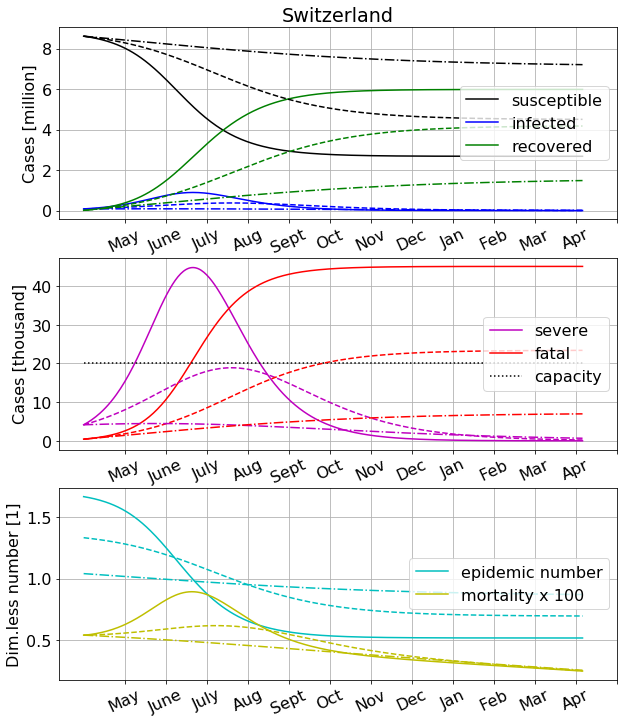

In [234]:
# set initial condition and parameter values for the model
I0    = 16605*5 # current infected count
R0    = 2967*5  # current recovered count
D0    = 433     # current fatality count
P0    = 8.7e6   # population size
C0    = 2e4     # bed capacity of health care system
beta  = 0.12    # estimated infection rate parameter
gamma = 1/14    # estimated recovery rate parameter
delta = 0.005   # estimated mortality rate parameter
r_hsp = 0.05    # estimated hospitalisation rate
f_dst = 1.00    # factor for reduction in infection rate due to social distancing
f_rst = 1.00    # factor for reduction in effective population size due to travel restrictions
f_snl = 0.00    # increase seasonality of infection rate (>0 for norther, <0 for southern hemisphere)
f_str = 0.02    # factor for increase in mortality rate for health service at/over capacity
f_dcy = 0.50    # factor for increase in yearly decay of mortality rate (weaker form of virus spread further)
t_end = 365     # model duration in days

# run the model with the above choices
Time, S_1, I_1, R_1, D_1, RI_1, RO_1, RM_1 = SIRD(I0, R0, D0, P0, C0, beta, gamma, delta, 1.00, f_rst, f_snl, f_str, f_dcy, t_end)
Time, S_2, I_2, R_2, D_2, RI_2, RO_2, RM_2 = SIRD(I0, R0, D0, P0, C0, beta, gamma, delta, 0.80, f_rst, f_snl, f_str, f_dcy, t_end)
Time, S_3, I_3, R_3, D_3, RI_3, RO_3, RM_3 = SIRD(I0, R0, D0, P0, C0, beta, gamma, delta, 0.625, f_rst, f_snl, f_str, f_dcy, t_end)

# calculate dimensionless numbers
RE_1 = RI_1*S_1/RO_1
RE_2 = RI_2*S_2/RO_2
RE_3 = RI_3*S_3/RO_3

RR_1 = (1-RM_1)*RO_1/RI_1/S_1
RR_2 = (1-RM_2)*RO_2/RI_2/S_2
RR_3 = (1-RM_3)*RO_3/RI_3/S_3

RD_1 =    RM_1 *RO_1/RI_1/S_1
RD_2 =    RM_2 *RO_2/RI_2/S_2
RD_3 =    RM_3 *RO_3/RI_3/S_3

fig1 = plt.figure(1,figsize=(10,12))  # create figure to plot in

plt.subplot(3,1,1)
plt.plot(Time,S_1*P0/mega,'k-' ,Time,I_1*P0/mega,'b-' ,Time,R_1*P0/mega,'g-' , \
         Time,S_2*P0/mega,'k--',Time,I_2*P0/mega,'b--',Time,R_2*P0/mega,'g--', \
         Time,S_3*P0/mega,'k-.',Time,I_3*P0/mega,'b-.',Time,R_3*P0/mega,'g-.')
plt.ylabel('Cases [million]');
plt.grid(True)
plt.xticks(np.arange(0,t_end,30)+shift, ('May','June','July','Aug','Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr'), rotation=25)
plt.legend(['susceptible','infected','recovered'],loc=7)
plt.title('Switzerland')

plt.subplot(3,1,2)
plt.plot(Time,I_1*r_hsp*P0/kilo,'m-' ,Time,D_1*P0/kilo,'r-' ,[Time[0],Time[-1]],[C0/kilo,C0/kilo],'k:', \
         Time,I_2*r_hsp*P0/kilo,'m--',Time,D_2*P0/kilo,'r--', \
         Time,I_3*r_hsp*P0/kilo,'m-.',Time,D_3*P0/kilo,'r-.')
plt.ylabel('Cases [thousand]');
plt.grid(True)
plt.xticks(np.arange(0,t_end,30)+shift, ('May','June','July','Aug','Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr'), rotation=25)
plt.legend(['severe','fatal','capacity'],loc=7);

plt.subplot(3,1,3)
plt.plot(Time,RE_1,'c-' ,Time,RM_1*100,'y-' , \
         Time,RE_2,'c--',Time,RM_2*100,'y--', \
         Time,RE_3,'c-.',Time,RM_3*100,'y-.')
plt.ylabel('Dim.less number [1]');
plt.grid(True)
plt.xticks(np.arange(0,t_end,30)+shift, ('May','June','July','Aug','Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr'), rotation=25)
plt.legend(['epidemic number','mortality x 100'],loc=7);

plt.savefig("CH-1April.png",dpi=600)

## Model projection for IT

This projection is based on the latest case count and best estimate growth and mortality rates for Italy.

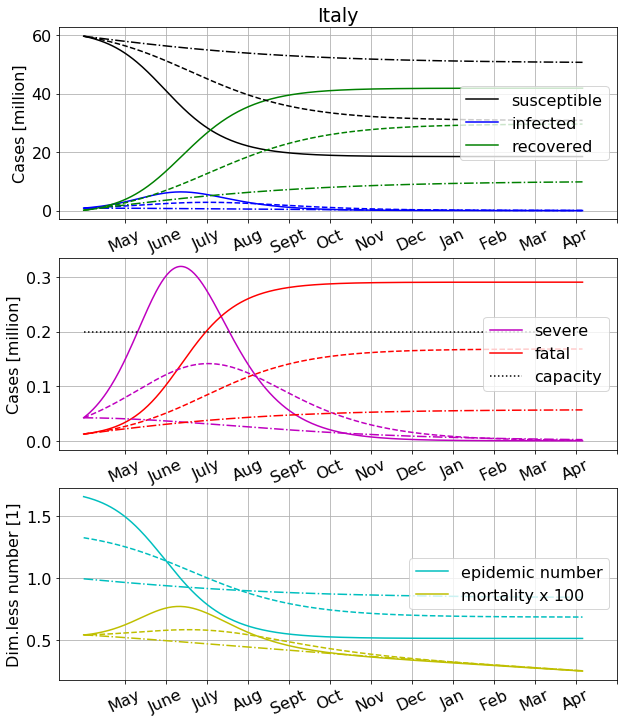

In [228]:
# set initial condition and parameter values for the model
I0    = 105792*8 # current infected count
R0    = 15729*8  # current recovered count
D0    = 12428    # current fatality count
P0    = 60.5e6   # population size
C0    = 2e5      # bed capacity of health care system
beta  = 0.12     # estimated infection rate parameter
gamma = 1/14     # estimated recovery rate parameter
delta = 0.005    # estimated mortality rate parameter
r_hsp = 0.05     # estimated hospitalisation rate
f_dst = 1.00     # factor for reduction in infection rate due to social distancing
f_rst = 1.00     # factor for reduction in effective population size due to travel restrictions
f_snl = 0.00     # increase seasonality of infection rate (>0 for norther, <0 for southern hemisphere)
f_str = 0.02     # factor for increase in mortality rate for health service at/over capacity
f_dcy = 0.50     # factor for increase in yearly decay of mortality rate (weaker form of virus spread further)
t_end = 365      # model duration in days

# run the model with the above choices
Time, S_1, I_1, R_1, D_1, RI_1, RO_1, RM_1 = SIRD(I0, R0, D0, P0, C0, beta, gamma, delta, 1.00, f_rst, f_snl, f_str, f_dcy, t_end)
Time, S_2, I_2, R_2, D_2, RI_2, RO_2, RM_2 = SIRD(I0, R0, D0, P0, C0, beta, gamma, delta, 0.80, f_rst, f_snl, f_str, f_dcy, t_end)
Time, S_3, I_3, R_3, D_3, RI_3, RO_3, RM_3 = SIRD(I0, R0, D0, P0, C0, beta, gamma, delta, 0.60, f_rst, f_snl, f_str, f_dcy, t_end)

# calculate dimensionless numbers
RE_1 = RI_1*S_1/RO_1
RE_2 = RI_2*S_2/RO_2
RE_3 = RI_3*S_3/RO_3

RR_1 = (1-RM_1)*RO_1/RI_1/S_1
RR_2 = (1-RM_2)*RO_2/RI_2/S_2
RR_3 = (1-RM_3)*RO_3/RI_3/S_3

RD_1 =    RM_1 *RO_1/RI_1/S_1
RD_2 =    RM_2 *RO_2/RI_2/S_2
RD_3 =    RM_3 *RO_3/RI_3/S_3

fig1 = plt.figure(1,figsize=(10,12))  # create figure to plot in
    
plt.subplot(3,1,1)
plt.plot(Time,S_1*P0/mega,'k-' ,Time,I_1*P0/mega,'b-' ,Time,R_1*P0/mega,'g-' , \
         Time,S_2*P0/mega,'k--',Time,I_2*P0/mega,'b--',Time,R_2*P0/mega,'g--', \
         Time,S_3*P0/mega,'k-.',Time,I_3*P0/mega,'b-.',Time,R_3*P0/mega,'g-.')
plt.ylabel('Cases [million]');
plt.grid(True)
plt.xticks(np.arange(0,t_end,30)+shift, ('May','June','July','Aug','Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr'), rotation=25)
plt.legend(['susceptible','infected','recovered'],loc=7)
plt.title('Italy')

plt.subplot(3,1,2)
plt.plot(Time,I_1*r_hsp*P0/mega,'m-' ,Time,D_1*P0/mega,'r-' ,[Time[0],Time[-1]],[C0/mega,C0/mega],'k:', \
         Time,I_2*r_hsp*P0/mega,'m--',Time,D_2*P0/mega,'r--', \
         Time,I_3*r_hsp*P0/mega,'m-.',Time,D_3*P0/mega,'r-.')
plt.ylabel('Cases [million]');
plt.grid(True)
plt.xticks(np.arange(0,t_end,30)+shift, ('May','June','July','Aug','Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr'), rotation=25)
plt.legend(['severe','fatal','capacity'],loc=7);

plt.subplot(3,1,3)
plt.plot(Time,RE_1,'c-' ,Time,RM_1*100,'y-' , \
         Time,RE_2,'c--',Time,RM_2*100,'y--', \
         Time,RE_3,'c-.',Time,RM_3*100,'y-.')
plt.ylabel('Dim.less number [1]');
plt.grid(True)
plt.xticks(np.arange(0,t_end,30)+shift, ('May','June','July','Aug','Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr'), rotation=25)
plt.legend(['epidemic number','mortality x 100'],loc=7);

plt.savefig("IT-1April.png",dpi=600)

## Model projection for USA

This projection is based on the latest case count and best estimate growth and mortality rates for the United States.

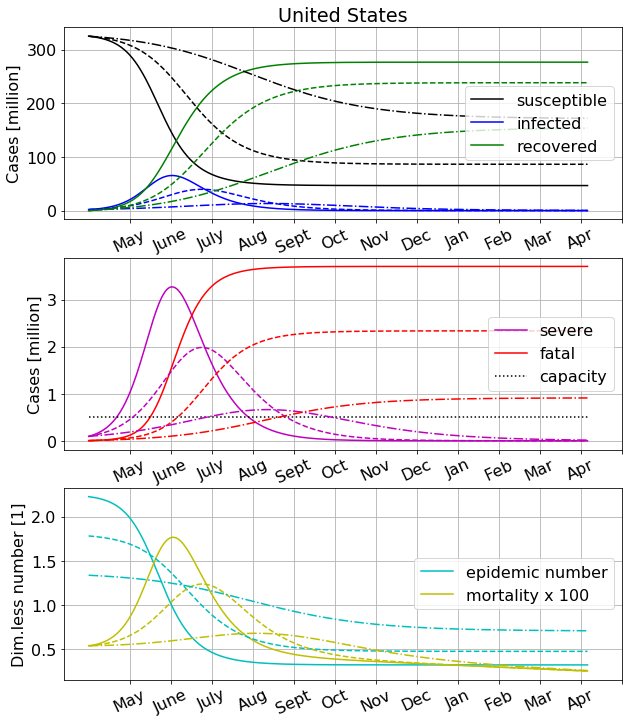

In [237]:
# set initial condition and parameter values for the model
I0    = 188647*10# current infected count
R0    = 7251*10  # current recovered count
D0    = 4059     # current fatality count
P0    = 327e6    # population size
C0    = 5e5      # bed capacity of health care system
beta  = 0.16     # estimated infection rate parameter
gamma = 1/14     # estimated recovery rate parameter
delta = 0.005    # estimated mortality rate parameter
r_hsp = 0.05     # estimated hospitalisation rate
f_dst = 1.00     # factor for reduction in infection rate due to social distancing
f_rst = 1.00     # factor for reduction in effective population size due to travel restrictions
f_snl = 0.00     # increase seasonality of infection rate (>0 for norther, <0 for southern hemisphere)
f_str = 0.02     # factor for increase in mortality rate for health service at/over capacity
f_dcy = 0.50     # factor for increase in yearly decay of mortality rate (weaker form of virus spread further)
t_end = 365      # model duration in days

# run the model with the above choices
Time, S_1, I_1, R_1, D_1, RI_1, RO_1, RM_1 = SIRD(I0, R0, D0, P0, C0, beta, gamma, delta, 1.00, f_rst, f_snl, f_str, f_dcy, t_end)
Time, S_2, I_2, R_2, D_2, RI_2, RO_2, RM_2 = SIRD(I0, R0, D0, P0, C0, beta, gamma, delta, 0.80, f_rst, f_snl, f_str, f_dcy, t_end)
Time, S_3, I_3, R_3, D_3, RI_3, RO_3, RM_3 = SIRD(I0, R0, D0, P0, C0, beta, gamma, delta, 0.60, f_rst, f_snl, f_str, f_dcy, t_end)

# calculate dimensionless numbers
RE_1 = RI_1*S_1/RO_1
RE_2 = RI_2*S_2/RO_2
RE_3 = RI_3*S_3/RO_3

RR_1 = (1-RM_1)*RO_1/RI_1/S_1
RR_2 = (1-RM_2)*RO_2/RI_2/S_2
RR_3 = (1-RM_3)*RO_3/RI_3/S_3

RD_1 =    RM_1 *RO_1/RI_1/S_1
RD_2 =    RM_2 *RO_2/RI_2/S_2
RD_3 =    RM_3 *RO_3/RI_3/S_3

fig1 = plt.figure(1,figsize=(10,12))  # create figure to plot in
    
plt.subplot(3,1,1)
plt.plot(Time,S_1*P0/mega,'k-' ,Time,I_1*P0/mega,'b-' ,Time,R_1*P0/mega,'g-' , \
         Time,S_2*P0/mega,'k--',Time,I_2*P0/mega,'b--',Time,R_2*P0/mega,'g--', \
         Time,S_3*P0/mega,'k-.',Time,I_3*P0/mega,'b-.',Time,R_3*P0/mega,'g-.')
plt.ylabel('Cases [million]');
plt.grid(True)
plt.xticks(np.arange(0,t_end,30)+shift, ('May','June','July','Aug','Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr'), rotation=25)
plt.legend(['susceptible','infected','recovered'],loc=7)
plt.title('United States')

plt.subplot(3,1,2)
plt.plot(Time,I_1*r_hsp*P0/mega,'m-' ,Time,D_1*P0/mega,'r-' ,[Time[0],Time[-1]],[C0/mega,C0/mega],'k:', \
         Time,I_2*r_hsp*P0/mega,'m--',Time,D_2*P0/mega,'r--', \
         Time,I_3*r_hsp*P0/mega,'m-.',Time,D_3*P0/mega,'r-.')
plt.ylabel('Cases [million]');
plt.grid(True)
plt.xticks(np.arange(0,t_end,30)+shift, ('May','June','July','Aug','Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr'), rotation=25)
plt.legend(['severe','fatal','capacity'],loc=7);

plt.subplot(3,1,3)
plt.plot(Time,RE_1,'c-' ,Time,RM_1*100,'y-' , \
         Time,RE_2,'c--',Time,RM_2*100,'y--', \
         Time,RE_3,'c-.',Time,RM_3*100,'y-.')
plt.ylabel('Dim.less number [1]');
plt.grid(True)
plt.xticks(np.arange(0,t_end,30)+shift, ('May','June','July','Aug','Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr'), rotation=25)
plt.legend(['epidemic number','mortality x 100'],loc=7);

plt.savefig("US-1April.png",dpi=600)